# Introduction

Welcome to the Eureka! tutorial - today we will learn how to run Eureka!'s S3 data reduction module, which takes 2D JWST data and reduces it to 1D spectra.

Eureka! is an open-source python package available for download at https://github.com/kevin218/Eureka (lead developers are Sebastian Zieba, Giannina Guzman Caloca, Kevin Stevenson, and Laura Kreidberg). Check out the docs at https://eurekadocs.readthedocs.io/en/latest/. Additional contribution are welcome! check out the issues page on github.

**One word of caution is that the package is under heavy development, so this tutorial is based on a stable release branch (release/v0.1). If you are using the ers-transit environment, it installs the stable release branch for you.** If you work with more recent versions of the code, it may not be backward compatible with this tutorial.


## Goals
- walk through all the major steps in data reduction
- get comfortable with the Eureka! structure and syntax
- most importantly, make sure none of the steps are a black box.

## Import standard python packages and Eureka!

In [12]:
import sys, os, time                                                            
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload                                                    
import eureka.S3_data_reduction.s3_reduce as s3                                 
from eureka.lib import readECF as rd                                            
from eureka.lib import logedit                                                  
from eureka.lib import readECF as rd                                            
from eureka.lib import manageevent as me                                        
from eureka.S3_data_reduction import optspex                                    
from eureka.lib import astropytable                                             
from eureka.lib import util                                                     
from eureka.S3_data_reduction import plots_s3

### Step 0: Initialization 

In [13]:
# Starts timer to monitor how long data reduction takes
t0      = time.time()

# Names the event (has to match the event name used for the *.ecf files)
eventlabel = 'wasp43b'                                                          
                                                                                
# Initialize metadata object to store all extra information 
# related to the event and the data reduction 

meta              = s3.Metadata()                                                 
meta.eventlabel   = eventlabel                                                    
                                                                                
# Initialize data object to store data from the observation                                                       
dat              = s3.Data()   

Try printing how much time has passed since the timer was initialized. Run the cell again. Do you see the time change?

In [14]:
print(time.time() - t0)  #time elapsed since the timer start

0.7425282001495361


In [15]:
# Load Eureka! control file and store values in Metadata object                    
ecffile = 'S3_' + eventlabel + '.ecf'                                           
ecf     = rd.read_ecf(ecffile)                                                  
rd.store_ecf(meta, ecf)  

Information from the ECF ("Eureka control file") is now stored in a Metadata object. This includes all the high level information about the data reduction (which JWST instrument was used? do we want to display plots? where is the data stored? what size is the extraction window? etc.)

To see the current contents of the Metadata object, type ``meta.__dict__.keys``. 

What is the value of ``meta.bg_deg``? Can you change it?

### Step 1: Make directories to store reduced data, create log file, read in data

In [16]:
# Create directories for Stage 3 processing                                     
datetime= time.strftime('%Y-%m-%d_%H-%M-%S')                                    
meta.workdir = 'S3_' + datetime + '_' + meta.eventlabel                             
if not os.path.exists(meta.workdir):                                              
    os.makedirs(meta.workdir)                                                     
if not os.path.exists(meta.workdir+"/figs"):                                      
    os.makedirs(meta.workdir+"/figs")                                             
                                                                                
# Load instrument module                                                        
exec('from eureka.S3_data_reduction import ' + meta.inst + ' as inst', globals()) 
reload(inst)                                                                    
                                                                                
# Open new log file                                                             
meta.logname  = './'+meta.workdir + '/S3_' + meta.eventlabel + ".log"                 
log         = logedit.Logedit(meta.logname)                                       
log.writelog("\nStarting Stage 3 Reduction")                                    
                                                                                
# Create list of file segments                                                  
meta = util.readfiles(meta)                                                         
num_data_files = len(meta.segment_list)                                           
log.writelog(f'\nFound {num_data_files} data file(s) ending in {meta.suffix}.fits')
                                                                                
stdspec = np.array([])


Starting Stage 3 Reduction

Found 21 data file(s) ending in calints.fits


*Important check!* Were the correct files read in? They are stored in ``meta.segment_list``.

### Step 2: read the data (and look at it!)

In [17]:
# pick a single file to read and reduce as a test
m = 17

# Read in data frame and header                                             
log.writelog(f'Reading file {m+1} of {num_data_files}')                     
dat = inst.read(meta.segment_list[m], dat, returnHdr=True)

Reading file 18 of 21


#### What data are we using?

The full description of the data is available [here](https://stsci.app.box.com/s/8r6kqh9m53jkwkff0scmed6zx42g307e/file/804595804746)). To quickly summarize, we are using simulated NIRCam grism time series data from the ERS Simulated Spectra Team.  The simulation assumes a WASP-43 b-like planet with physically realistic spectral features added. The simulated data are based on the following observational design:

- GRISMR+F322W2 pupil and filter
- RAPID readout mode
- 19 Groups per integrations
- 1287 integrations
- 1 Exposure
- 4 Output amplifiers
The data themselves are divided into “segments,” with each individual segment (seg001, seg002, etc.) containing a subset of the overall dataset. This is how flight data will be delivered. The segments are numbered in their order of observation.

We will use the Stage 2 Output from the [JWST data reduction pipeline](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/stages.html). For NIRCam, Stage 2 consists of the flat field correction, WCS/wavelength solution, and photometric calibration (counts/sec -> MJy). Note that this is specifically for NIRCam: the steps in Stage 2 change a bit depending on the instrument. The Stage 2 outputs are rougly equivalent to a “flt” file from HST.

The files have the suffix ``/*calints.fits`` which contain fully calibrated images (MJy) for each individual integration. This is the one you want if you’re starting with Stage 2 and want to do your own spectral extraction.

### Let's take a look at the data!
What is stored in the data object?

In [18]:
print(dat.__dict__.keys())

dict_keys(['mhdr', 'shdr', 'intstart', 'intend', 'data', 'err', 'dq', 'wave', 'v0', 'int_times'])


The calibrated 2D data, error array, data quality are stored in `data`, `err`, and `dq`. `wave` is the wavelength. 

The header information is stored in mhdr (main header) and shdr (science header). Use the headers to check whether the data is really from NIRCam.

In [19]:
dat.mhdr['INSTRUME']

'NIRCAM'

What units are the data stored in?

In [20]:
dat.shdr['BUNIT']

'MJy/sr'

#### What does the data look like??

Text(0, 0.5, 'spatial direction')

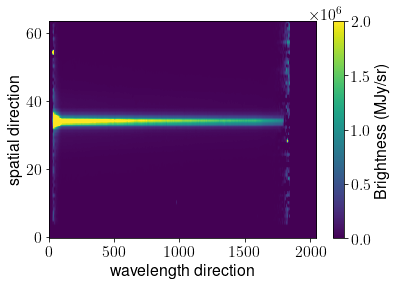

In [21]:
plt.imshow(dat.data[0], origin = 'lower', aspect='auto',  vmin=0, vmax=2e6)
ax = plt.gca()
plt.colorbar(label='Brightness (MJy/sr)')  #we will convert to photoelectrons later
ax.set_xlabel('wavelength direction')
ax.set_ylabel('spatial direction')

What happens if we change the contrast with the vmax parameter? what is the approximate background level? 

Text(0, 0.5, 'spatial direction')

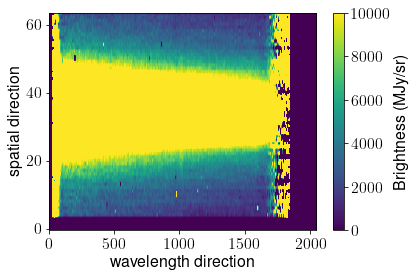

In [22]:
plt.imshow(dat.data[0], origin = 'lower', aspect='auto',  vmin=0, vmax=10000)
ax = plt.gca()
plt.colorbar(label='Brightness (MJy/sr)')
ax.set_xlabel('wavelength direction')
ax.set_ylabel('spatial direction')

How big should the extraction window be? Should it be symmetric? (Hint: we want to capture all the flux from the target star, but minimize the background)

Let's plot the spatial profile to see how wide the PSF is.

Text(0, 0.5, 'Flux (MJy/sr)')

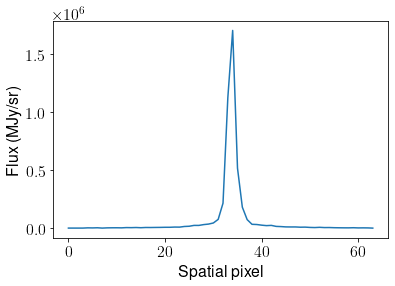

In [23]:
plt.plot(dat.data[0][:,1000]) #plots column 1000
plt.xlabel("Spatial pixel")
plt.ylabel("Flux (MJy/sr)")

Flux is mostly concentrated over a few pixels. But the wings are pretty wide! This is easier to see in log space:

<ipython-input-24-c1a7f222586f>:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(dat.data[0][:,1000]))  #plots log10 of column 1000
<ipython-input-24-c1a7f222586f>:1: RuntimeWarning: invalid value encountered in log10
  plt.plot(np.log10(dat.data[0][:,1000]))  #plots log10 of column 1000


Text(0, 0.5, 'Log10 Flux (MJy/sr)')

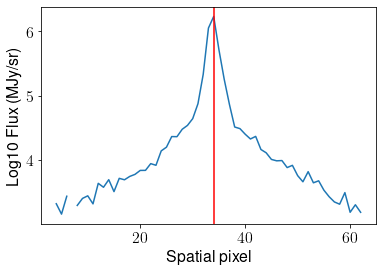

In [24]:
plt.plot(np.log10(dat.data[0][:,1000]))  #plots log10 of column 1000
ind_max = np.argmax(dat.data[0][:,1000]) #finds row where counts peak
plt.axvline(ind_max, color = 'red')      #marks peak counts with a red vertical line
plt.xlabel("Spatial pixel")
plt.ylabel("Log10 Flux (MJy/sr)")

### Decide which regions we want to use for the background and for the spectrum¶


In [25]:
# Get number of integrations and frame dimensions                               
meta.n_int, meta.ny, meta.nx = dat.data.shape 

# Saves source postion (accounting for window size)                                                       
meta.src_xpos = dat.shdr['SRCXPOS']-meta.xwindow[0]                             
meta.src_ypos = dat.shdr['SRCYPOS']-meta.ywindow[0]   

**Check which extraction window is saved in Metadata**

In [26]:
print(meta.xwindow)
print(meta.ywindow)

[100, 1700]
[5, 64]


In [27]:
# Trim data to subarray region of interest                                      
dat, meta = util.trim(dat, meta)

### Handle some unit conversion

In [29]:
#Convert units (eg. for NIRCam: MJy/sr -> DN -> Electrons)                      
dat, meta = inst.unit_convert(dat, meta, log)  

# Record integration mid-times in BJD_TDB                                       
dat.bjdtdb = dat.int_times['int_mid_BJD_TDB'] 

  Converting from brightness units (MJy/sr) to electrons


### Mask bad pixels

In [30]:
# Create bad pixel mask

dat.submask = np.ones(dat.subdata.shape)                                                                                                                          
                                                                                
# Check if arrays have NaNs                                                     
dat.submask = util.check_nans(dat.subdata, dat.submask, log)                    
dat.submask = util.check_nans(dat.suberr, dat.submask, log)                     
dat.submask = util.check_nans(dat.subv0, dat.submask, log) 

# Manually mask regions [colstart, colend, rowstart, rowend]                    
if hasattr(meta, 'manmask'):                                                    
    log.writelog("  Masking manually identified bad pixels")                    
    for i in range(len(meta.manmask)):                                          
        ind, colstart, colend, rowstart, rowend = meta.manmask[i]               
        dat.submask[rowstart:rowend,colstart:colend] = 0                        
                                                                             

In [31]:
# Perform outlier rejection of sky background along time axis                   
log.writelog('Performing background outlier rejection')                         
meta.bg_y1    = int(meta.src_ypos - meta.bg_hw)                                 
meta.bg_y2    = int(meta.src_ypos + meta.bg_hw)                                 
dat.submask = inst.flag_bg(dat, meta)       

Performing background outlier rejection


/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


### How many bad pixels were masked?

In [32]:
ny, nx = dat.submask.shape[1], dat.submask.shape[2]
print(ny, nx)
print(1. - np.sum(dat.submask[5])/(nx*ny))   # fraction of bad pixels in the integration

59 1600
0.0005190677966101509


### Subtract the background

In [33]:
dat = util.BGsubtraction(dat, meta, log, meta.isplots_S3)

  Performing background subtraction


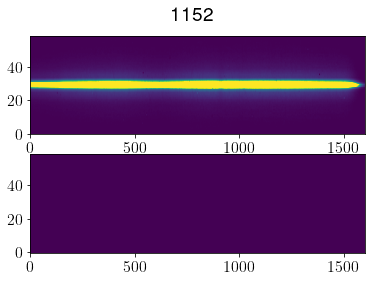

In [34]:
# Plots background-subtracted image (be patient, this can take a second!)
if meta.isplots_S3 >= 3:                                                        
    for n in range(meta.n_int):                                                 
        #make image+background plots                                            
        plots_s3.image_and_background(dat, meta, n)

  Performing background subtraction


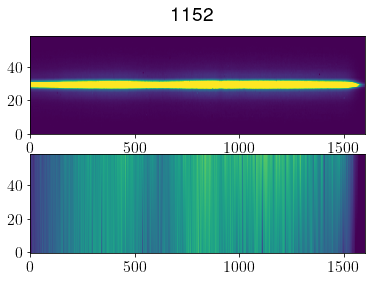

In [35]:
# Try doing a linear column-by-column fit to the background instead

meta.bg_deg = 1   #fits a polynomial of degree 1 to each column
dat = util.BGsubtraction(dat, meta, log, meta.isplots_S3)

# Plots background-subtracted image (be patient, this can take a second!)
if meta.isplots_S3 >= 3:                                                        
    for n in range(meta.n_int):                                                 
        #make image+background plots                                            
        plots_s3.image_and_background(dat, meta, n)  

### Time to extract the spectrum!!

In [36]:
# Select only aperture region                                                   
ap_y1       = int(meta.src_ypos - meta.spec_hw)                                 
ap_y2       = int(meta.src_ypos + meta.spec_hw)                                 
dat.apdata      = dat.subdata[:,ap_y1:ap_y2]                                    
dat.aperr       = dat.suberr [:,ap_y1:ap_y2]                                    
dat.apmask      = dat.submask[:,ap_y1:ap_y2]                                    
dat.apbg        = dat.subbg  [:,ap_y1:ap_y2]                                    
dat.apv0        = dat.subv0  [:,ap_y1:ap_y2]  

# Compute median frame                                                          
meta.medsubdata   = np.median(dat.subdata, axis=0)                              
meta.medapdata    = np.median(dat.apdata, axis=0)    

In [37]:
# Extract standard spectrum and its variance                                    
dat.stdspec     = np.sum(dat.apdata, axis=1)                                    
dat.stdvar      = np.sum(dat.aperr**2, axis=1)  

What does the standard spectrum look like?

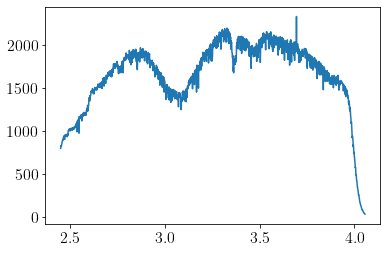

In [41]:
plt.plot(dat.subwave[meta.src_ypos], dat.stdspec[0])

Now let's do optimal extraction (this de-weights the wings of the spectrum that are background-dominated)

  Performing optimal spectral extraction


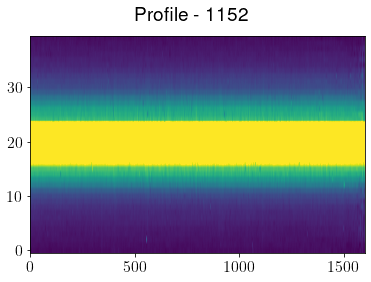

In [42]:
# Extract optimal spectrum with uncertainties                                   
log.writelog("  Performing optimal spectral extraction")                        
dat.optspec     = np.zeros((dat.stdspec.shape))                                 
dat.opterr      = np.zeros((dat.stdspec.shape))                                 
gain        = 1         #FINDME: need to determine correct gain                 
for n in range(meta.n_int):                                                     
    dat.optspec[n], dat.opterr[n], mask = optspex.optimize(dat.apdata[n], dat.apmask[n], dat.apbg[n], dat.stdspec[n], gain, dat.apv0[n], p5thresh=meta.p5thresh, p7thresh=meta.p7thresh, fittype=meta.fittype, window_len=meta.window_len, deg=meta.prof_deg, n=dat.intstart+n, isplots=meta.isplots_S3, eventdir=meta.workdir, meddata=meta.medapdata)

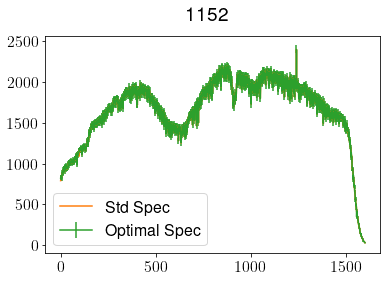

In [43]:
# Plotting results                                                              
if meta.isplots_S3 >= 3:                                                        
    for n in range(meta.n_int):                                                 
        #make optimal spectrum plot                                             
        plots_s3.optimal_spectrum(dat, meta, n)

### Save results and generate final figures

In [45]:
# Append results                                                                
if len(stdspec) == 0:                                                           
    wave_2d  = dat.subwave                                                      
    wave_1d  = dat.subwave[meta.src_ypos]                                       
    stdspec  = dat.stdspec                                                      
    stdvar   = dat.stdvar                                                       
    optspec  = dat.optspec                                                      
    opterr   = dat.opterr                                                       
    bjdtdb   = dat.bjdtdb                                                       
else:                                                                           
    stdspec  = np.append(stdspec, dat.stdspec, axis=0)                          
    stdvar   = np.append(stdvar, dat.stdvar, axis=0)                            
    optspec  = np.append(optspec, dat.optspec, axis=0)                          
    opterr   = np.append(opterr, dat.opterr, axis=0)                            
    bjdtdb   = np.append(bjdtdb, dat.bjdtdb, axis=0)                            
                                                                                
# Calculate total time                                                          
total = (time.time() - t0)/60.                                                  
log.writelog('\nTotal time (min): ' + str(np.round(total,2)))                   
                                                                                
                                                                                
# Save results                                                                  
log.writelog('Saving results')                                                  
me.saveevent(meta, meta.workdir + '/S3_' + meta.eventlabel + "_Meta_Save", save=[])
                                                                                
# Save results                                                                  
log.writelog('Saving results')                                                  
me.saveevent(dat, meta.workdir + '/S3_' + meta.eventlabel + "_Data_Save", save=[])
                                                                                
log.writelog('Saving results as astropy table...')                              
astropytable.savetable(meta, bjdtdb, wave_1d, stdspec, stdvar, optspec, opterr)
                                                                                
log.writelog('Generating figures')                                              
if meta.isplots_S3 >= 1:                                                        
# 2D light curve without drift correction                                       
    plots_s3.lc_nodriftcorr(meta, wave_1d, optspec)                             
                                                                                
log.closelog()    


Total time (min): 3.72


ValueError: I/O operation on closed file.

# Now let's make lightcurves!

This is Stage 4 of the Eureka! pipeline. It takes the time series of spectra from Stage 3 and bins them into wavelength channels.

In [70]:
#importing Eureka! Stage 4 modules
import eureka.S4_generate_lightcurves.s4_genLC as s4
import eureka.S4_generate_lightcurves.plots_s4 as plots_s4

# Load Eureka! control file and store values in Event object                    
ecffile = 'S4_' + eventlabel + '.ecf'                                           
ecf     = rd.read_ecf(ecffile)                                                  
rd.store_ecf(meta, ecf)     

# Create directories for Stage 3 processing                                     
datetime= time.strftime('%Y-%m-%d_%H-%M-%S')                                    
meta.lcdir = meta.workdir + '/S4_' + datetime + '_' + str(meta.nspecchan) + 'chan'
if not os.path.exists(meta.lcdir):                                              
    os.makedirs(meta.lcdir)                                                     
if not os.path.exists(meta.lcdir+"/figs"):                                      
    os.makedirs(meta.lcdir+"/figs")
    
# Copy existing S3 log file                                                     
meta.s4_logname  = './'+meta.lcdir + '/S4_' + meta.eventlabel + ".log"          
#shutil.copyfile(ev.logname, ev.s4_logname, follow_symlinks=True)               
log         = logedit.Logedit(meta.s4_logname, read=meta.logname)               
log.writelog("\nStarting Stage 4: Generate Light Curves\n")


Starting Stage 4: Generate Light Curves



### Store the 1D optimally extracted spectra, wavelengths, and times

In [72]:
table = astropytable.readtable(meta)                                            
                                                                                
optspec, wave_1d, bjdtdb = np.reshape(table['optspec'].data, (-1, meta.subnx)), \
                           table['wave_1d'].data[0:meta.subnx], table['bjdtdb'].data[::meta.subnx]
                                                                                
#Replace NaNs with zero                                                         
optspec[np.where(np.isnan(optspec))] = 0      

### Specify wavelength bins

In [74]:
# Determine wavelength bins                                                     
binsize     = (meta.wave_max - meta.wave_min)/meta.nspecchan                    
meta.wave_low = np.round([i for i in np.linspace(meta.wave_min, meta.wave_max-binsize, meta.nspecchan)],3)
meta.wave_hi  = np.round([i for i in np.linspace(meta.wave_min+binsize, meta.wave_max, meta.nspecchan)],3)

## Make the lightcurves!!!

### Important sanity check: do the error bars on the data points look correct to you ? If not, why not?

Generating light curves
Bandpass 0 = 2.500 - 2.650
Bandpass 1 = 2.650 - 2.800
Bandpass 2 = 2.800 - 2.950
Bandpass 3 = 2.950 - 3.100
Bandpass 4 = 3.100 - 3.250
Bandpass 5 = 3.250 - 3.400
Bandpass 6 = 3.400 - 3.550
Bandpass 7 = 3.550 - 3.700
Bandpass 8 = 3.700 - 3.850
Bandpass 9 = 3.850 - 4.000


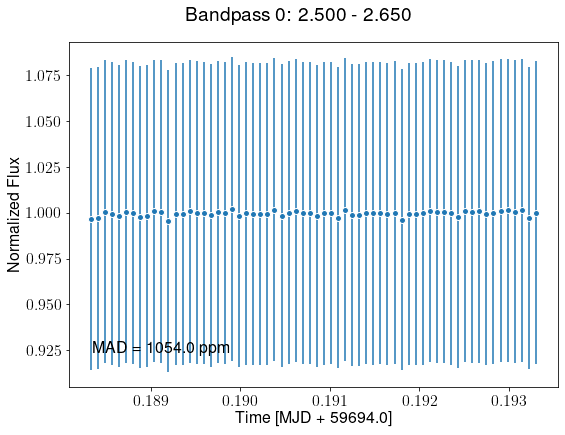

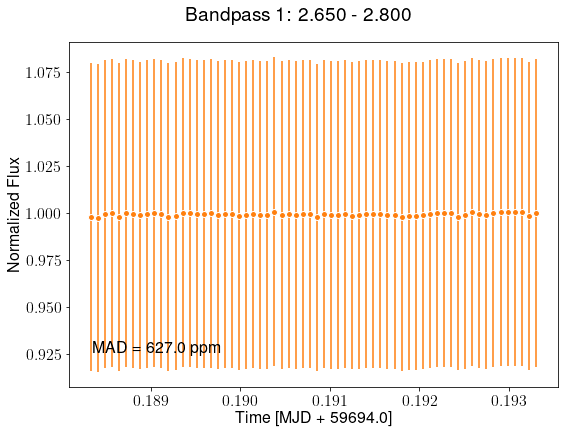

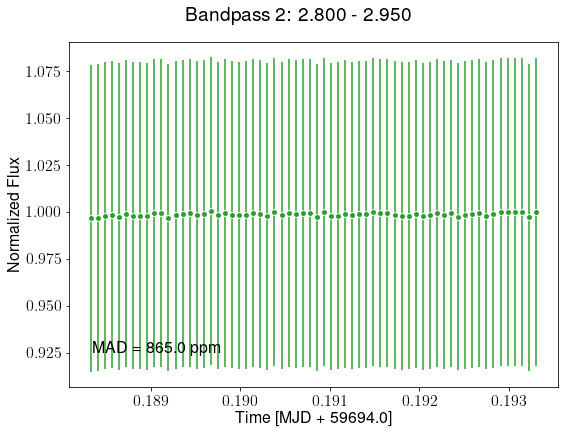

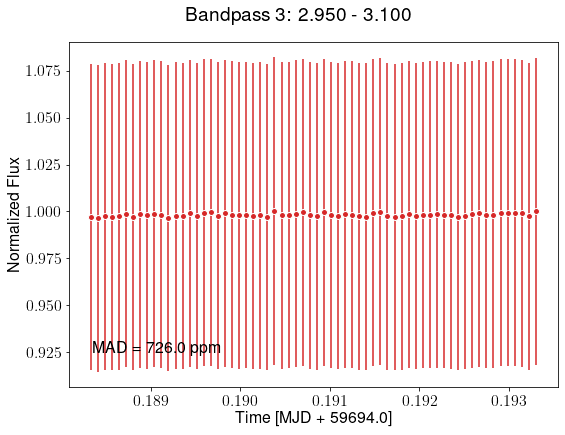

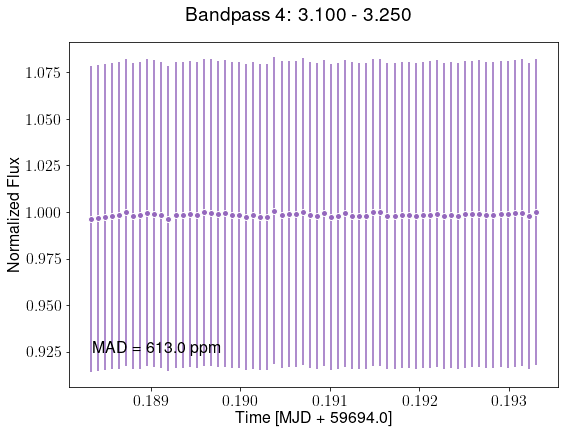

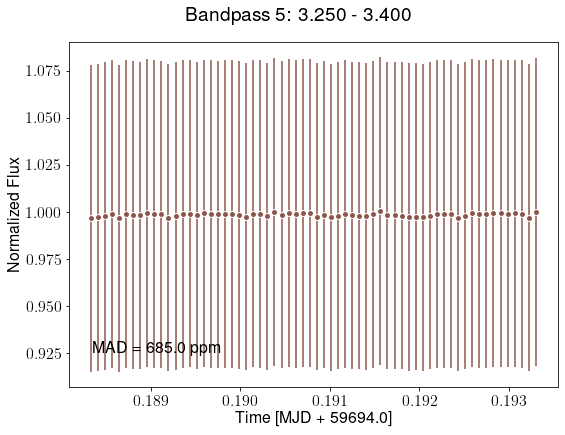

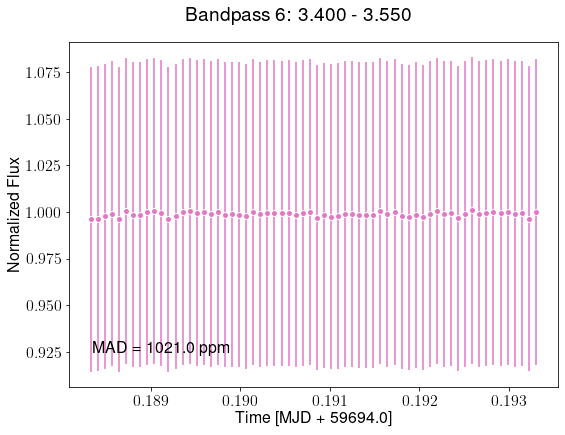

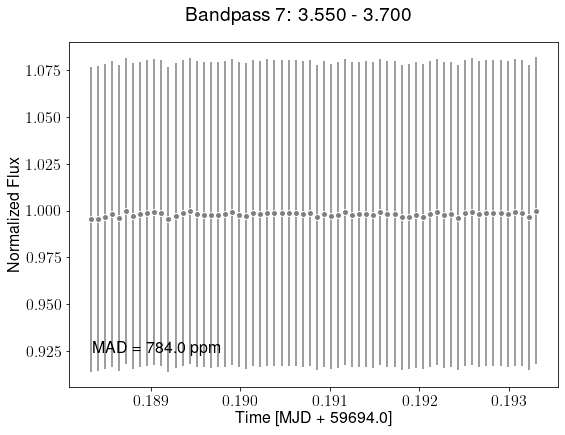

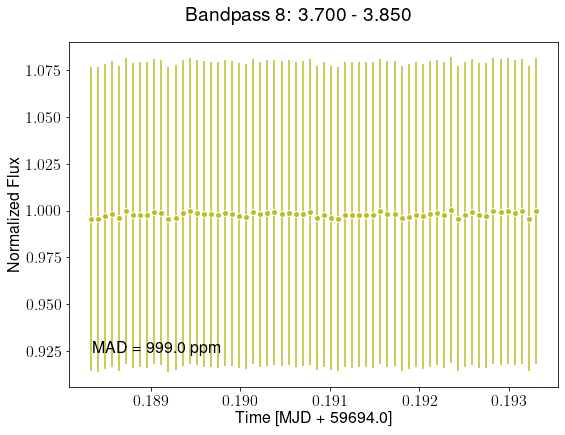

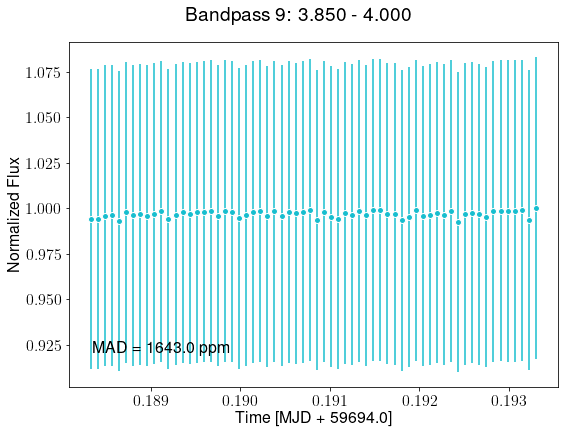

In [67]:
log.writelog("Generating light curves")                                         
n_int, nx   = optspec.shape                                                     
meta.lcdata   = np.zeros((meta.nspecchan, n_int))                               
meta.lcerr    = np.zeros((meta.nspecchan, n_int))                               
                                                                                
for i in range(meta.nspecchan):                                                 
    log.writelog(f"Bandpass {i} = %.3f - %.3f" % (meta.wave_low[i],meta.wave_hi[i]))
                                                                                
    # Compute valid indices within wavelength range                             
    index   = np.where((wave_1d >= meta.wave_low[i])*(wave_1d <= meta.wave_hi[i]))[0]
    # Sum flux for each spectroscopic channel                                   
    meta.lcdata[i]    = np.sum(optspec[:,index],axis=1)                         
    # Add uncertainties in quadrature                                           
    meta.lcerr[i]     = np.sqrt(np.sum(optspec[:,index]**2,axis=1))             
                                                                                
    # Plot each spectroscopic light curve                                       
    if meta.isplots_S4 >= 3:                                                    
        plots_s4.binned_lightcurve(meta, bjdtdb, i)

In [68]:
# Save results                                                                  
log.writelog('Saving results')                                                  
me.saveevent(meta, meta.lcdir + '/S4_' + meta.eventlabel + "_Meta_Save", save=[])
                                                                                
                                                                                
                                                                                
log.closelog()                                                                  

Saving results


## Final note: the error bars are in fact not correct, due to a bug in the NIRCam error arrays. This is a reminder to always check whether the results from your pipeline make sense!!